<a href="https://colab.research.google.com/github/nalbarr/pytorch-spine-binary-classifier/blob/master/pytorch_spine_binary_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pytorch-spine-binary-classifier

#### References
- https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89
- https://www.kaggle.com/sammy123/lower-back-pain-symptoms-dataset?select=Dataset_spine.csv

### Dataset 

310 Observations, 13 Attributes (12 Numeric Predictors, 1 Binary Class Attribute - No Demographics)

Lower back pain can be caused by a variety of problems with any parts of the complex, interconnected network of spinal muscles, nerves, bones, discs or tendons in the lumbar spine. Typical sources of low back pain include:

The large nerve roots in the low back that go to the legs may be irritated
The smaller nerves that supply the low back may be irritated
The large paired lower back muscles (erector spinae) may be strained
The bones, ligaments or joints may be damaged
An intervertebral disc may be degenerating
An irritation or problem with any of these structures can cause lower back pain and/or pain that radiates or is referred to other parts of the body. Many lower back problems also cause back muscle spasms, which don't sound like much but can cause severe pain and disability.

While lower back pain is extremely common, the symptoms and severity of lower back pain vary greatly. A simple lower back muscle strain might be excruciating enough to necessitate an emergency room visit, while a degenerating disc might cause only mild, intermittent discomfort.

This data set is about to identify a person is abnormal or normal using collected physical spine details/data.

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [0]:
!git clone https://github.com/nalbarr/pytorch-spine-binary-classifier

fatal: destination path 'pytorch-spine-binary-classifier' already exists and is not an empty directory.


In [0]:
!ls

pytorch-spine-binary-classifier  sample_data


In [0]:
# read data
df = pd.read_csv("pytorch-spine-binary-classifier/spine.csv")
df.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att,Unnamed: 13
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal,NaN
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal,NaN
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal,Prediction is done by using binary classificat...
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal,NaN
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal,NaN


In [0]:
# drop last column
df = df.drop(df.columns[-1],axis=1)
df.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal


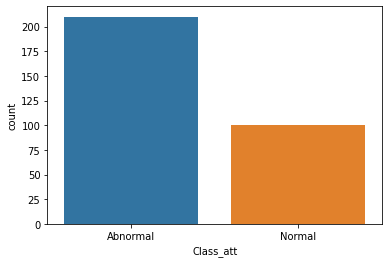

In [0]:
# class distribution
sns.countplot(x = 'Class_att', data=df)

In [0]:
# map target labels as numerical - 0 = normal, 1 = abnormal
df['Class_att'] = df['Class_att'].astype('category')
encode_map = {
    'Abnormal': 1,
    'Normal': 0
}

df['Class_att'].replace(encode_map, inplace=True)

In [0]:
df['Class_att']

0      1
1      1
2      1
3      1
4      1
      ..
305    0
306    0
307    0
308    0
309    0
Name: Class_att, Length: 310, dtype: int64

In [0]:
# create input and output data
X = df.iloc[:, 0:-1]
# NAA. Not sure why there is an extra Unnamed column.  I had to manually drop last column.
y = df.iloc[:, -1]

In [0]:
y

0      1
1      1
2      1
3      1
4      1
      ..
305    0
306    0
307    0
308    0
309    0
Name: Class_att, Length: 310, dtype: int64

In [0]:
# split data for train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)

In [0]:
# standardize input (i.e., mean = 0, std = 1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [0]:
print(type(X_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [0]:
# model parameters
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

### Custom Data Loaders

In [0]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))

In [0]:
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

In [0]:
# initialize data loaders
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

### Define Model

Note that we did not use the Sigmoid activation in our final layer during training. That’s because, we use the nn.BCEWithLogitsLoss() loss function which automatically applies the the Sigmoid activation. We however, need to use Sigmoid manually during inference.

In [0]:
# 2 layer FF DNN with BatchNorm and Dropout
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(12, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [0]:
# check GPU, etc.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# NAA
# - will output cuda:0 if GPU

cuda:0


In [0]:
!nvidia-smi

Fri May 29 19:26:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    31W / 250W |    709MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# initialize optimizer, loss function
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=12, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


### Train model

In [0]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [0]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # NAA. Important !!! Zero gradients each epoch run
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.73962 | Acc: 47.250
Epoch 002: | Loss: 0.63003 | Acc: 65.500
Epoch 003: | Loss: 0.56096 | Acc: 72.250
Epoch 004: | Loss: 0.58153 | Acc: 70.750
Epoch 005: | Loss: 0.49077 | Acc: 81.000
Epoch 006: | Loss: 0.48003 | Acc: 80.250
Epoch 007: | Loss: 0.45043 | Acc: 80.250
Epoch 008: | Loss: 0.44272 | Acc: 79.250
Epoch 009: | Loss: 0.40486 | Acc: 83.250
Epoch 010: | Loss: 0.45481 | Acc: 84.000
Epoch 011: | Loss: 0.39188 | Acc: 84.250
Epoch 012: | Loss: 0.36724 | Acc: 86.250
Epoch 013: | Loss: 0.34218 | Acc: 88.500
Epoch 014: | Loss: 0.36552 | Acc: 87.250
Epoch 015: | Loss: 0.32444 | Acc: 89.000
Epoch 016: | Loss: 0.31092 | Acc: 91.750
Epoch 017: | Loss: 0.34616 | Acc: 86.000
Epoch 018: | Loss: 0.32867 | Acc: 87.000
Epoch 019: | Loss: 0.25177 | Acc: 92.500
Epoch 020: | Loss: 0.26136 | Acc: 92.750
Epoch 021: | Loss: 0.23494 | Acc: 92.500
Epoch 022: | Loss: 0.28564 | Acc: 88.750
Epoch 023: | Loss: 0.25272 | Acc: 90.000
Epoch 024: | Loss: 0.20386 | Acc: 93.500
Epoch 025: | Los

### Test Model

In [0]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

### Evaluate Model

In [0]:
confusion_matrix(y_test, y_pred_list)

array([[26,  5],
       [17, 55]])

In [0]:
# dump precision, recall, F1
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.60      0.84      0.70        31
           1       0.92      0.76      0.83        72

    accuracy                           0.79       103
   macro avg       0.76      0.80      0.77       103
weighted avg       0.82      0.79      0.79       103

